# Piecewise linear trends & changepoints

In this notebook we will show how to create features to capture changepoints by building a piecewise linear regression. We will use recursive forecasting to see how we can use this in practice!

We will work with a monthly retail sales dataset (found [here](https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv)).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 1, in the folder "01-Create-Datasets" from this repo.

## Data Set Synopsis

The timeseries is between January 1992 and Apr 2005.

It consists of a single series of monthly values representing sales volumes. 

In [64]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context("talk")

In [65]:
data = pd.read_csv(
    "../Datasets/example_retail_sales.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

# Plot time series

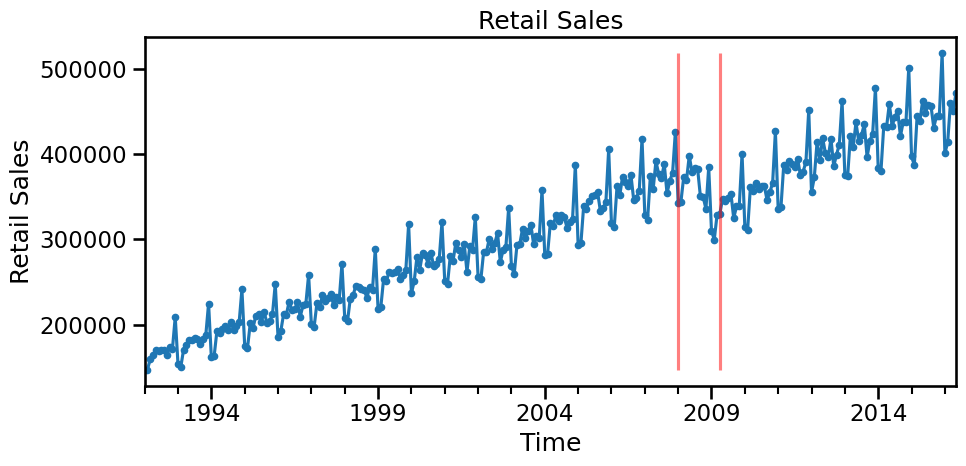

In [66]:
fig, ax = plt.subplots(figsize=[10, 5])
data.plot(y="y", marker=".", figsize=[10, 5], legend=None, ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Retail Sales")
ax.set_title("Retail Sales")
ax.vlines(
    ["2008-01-01", "2009-04-01"],
    ymin=data["y"].min(),
    ymax=data["y"].max(),
    color="r",
    alpha=0.5,
)
plt.tight_layout()

# Creating the features with Pandas

In [67]:
df = data.copy()

Specify the timepoints to create our trend and changepoint features.

In [68]:
changepoints = [
    "1992-01-01",  # start of time series
    "2008-01-01",  # changepoint
    "2009-04-01",  # changepoint
]

In [69]:
# loop over the change points
for changepoint in changepoints:
    
    # convert the string date into pandas datetime object
    changepoint_dt = pd.to_datetime(changepoint)

    # set a name to the feature
    feat_name = f"time_since_{changepoint_dt}"

    # compute time diferences between each date with the change point 
    time_diff = df.index - changepoint_dt 
 
    # Convert from time delta to numeric
    time_diff = np.round(time_diff / np.timedelta64(1, "M"))

    #  set the value into the feature
    df[feat_name] = time_diff

    # trim the value by a treshold
    df[feat_name] = df[feat_name].clip(0)

In [70]:
df

,y,time_since_1992-01-01 00:00:00,time_since_2008-01-01 00:00:00,time_since_2009-04-01 00:00:00
ds,,,,
1992-01-01,146376,0.0,0.0,0.0
1992-02-01,147079,1.0,0.0,0.0
1992-03-01,159336,2.0,0.0,0.0
1992-04-01,163669,3.0,0.0,0.0
1992-05-01,170068,4.0,0.0,0.0
...,...,...,...,...
2016-01-01,400928,288.0,96.0,81.0
2016-02-01,413554,289.0,97.0,82.0
2016-03-01,460093,290.0,98.0,83.0


In [71]:
# look at the tried change point where the change is happend
df.loc[
    changepoint_dt - np.timedelta64(3, "M") : changepoint_dt + np.timedelta64(3, "M")
]

,y,time_since_1992-01-01 00:00:00,time_since_2008-01-01 00:00:00,time_since_2009-04-01 00:00:00
ds,,,,
2009-01-01,310269,204.0,12.0,0.0
2009-02-01,299488,205.0,13.0,0.0
2009-03-01,328568,206.0,14.0,0.0
2009-04-01,329866,207.0,15.0,0.0
2009-05-01,347768,208.0,16.0,1.0
2009-06-01,344439,209.0,17.0,2.0
2009-07-01,348106,210.0,18.0,3.0


# Creating the features with sktime 

In [72]:
from sktime.transformations.series.time_since import TimeSince

In [73]:
df = data.copy()

Manually specify the changepoints.

In [74]:
# Specify changepoints
changepoints = [
    "1992-01-01",  # start of time series
    "2008-01-01",  # changepoint
    "2009-04-01",  # changepoint
]

Use the `TimeSince` transformer to create the changepoint features.

In [75]:
# create TimeSince transformer for change point features
time_since_transformer = TimeSince(
    start=changepoints, # the change point list 
    positive_only=True, # before each change point, the values will bw 0 
    keep_original_columns=True
)

df = time_since_transformer.fit_transform(df)

In [76]:
df.loc["2007-10":].head(10)

,y,time_since_1992-01-01 00:00:00,time_since_2008-01-01 00:00:00,time_since_2009-04-01 00:00:00
ds,,,,
2007-10-01,368681,189,0,0
2007-11-01,377802,190,0,0
2007-12-01,426077,191,0,0
2008-01-01,342697,192,0,0
2008-02-01,343937,193,1,0
2008-03-01,372923,194,2,0
2008-04-01,368923,195,3,0
2008-05-01,397969,196,4,0
2008-06-01,378490,197,5,0


# Let's build a forecast!

Let's build a recursive forecast and see how our changepoint features can help!

In [77]:
# Let's ensure all sklearn transformers output pandas dataframes
from sklearn import set_config
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince

set_config(transform_output="pandas")  # Upgrade to scikit-learn 0.12
# for this feature

In [78]:
df = data.copy()
df.head()

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


Specify target name.

In [79]:
target = ["y"]  # Note: it's in a list.
# This ensures we'll get
# a dataframe when using df.loc[:, target]
# rather than a pandas Series.
# This can also be useful if we have
# multiple targets.

Prepare our transformers.

In [80]:
# Polynomial time features
time_feats = make_pipeline(
    TimeSince(), PolynomialFeatures(degree=1, include_bias=False)
)

# Compute features for piecewise regression
# which helps us handle changepoints.
changepoints = [
    "2008-01-01",  # changepoint
    "2009-04-01",  # changepoint
]

changepoint_feats = TimeSince(changepoints, positive_only=True)

# Features computed from the target.
# Compute lag and window features.
lag_window_feats = WindowSummarizer(
    lag_feature={
        "lag": [1],  # Lag features.
        # "mean": [[1, 12]],  # [[lag, window size]]
    },
    target_cols=target, # drop the target column, return only the lags features
    truncate="bfill",  # Backfill missing values from lagging and windowing.
)

Create a pipeline to create all our features.

In [81]:
# Create features derived independent of one another
pipeline = make_union(time_feats, changepoint_feats, lag_window_feats)

# Apply min-max scaling to all the features
pipeline = make_pipeline(pipeline, MinMaxScaler())

In [82]:
pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline',
                                                 Pipeline(steps=[('timesince',
                                                                  TimeSince()),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures(degree=1,
                                                                                     include_bias=False))])),
                                                ('timesince',
                                                 TimeSince(positive_only=True, start=['2008-01-01', '2009-04-01'])),
                                                ('windowsummarizer',
                                                 WindowSummarizer(lag_feature={'lag': [1]}, target_cols=['y'], truncate='bfill'))])),
                ('minmaxscaler', MinMaxScaler())])

Let's check how our feature engineering pipeline behaves.

In [83]:
pipeline.fit_transform(df)

,time_since_1992-01-01 00:00:00,time_since_2008-01-01 00:00:00,time_since_2009-04-01 00:00:00,y_lag_1
ds,,,,
1992-01-01,0.000000,0.00,0.000000,0.000000
1992-02-01,0.003425,0.00,0.000000,0.000000
1992-03-01,0.006849,0.00,0.000000,0.001890
1992-04-01,0.010274,0.00,0.000000,0.034850
1992-05-01,0.013699,0.00,0.000000,0.046502
...,...,...,...,...
2016-01-01,0.986301,0.96,0.952941,1.000000
2016-02-01,0.989726,0.97,0.964706,0.684506
2016-03-01,0.993151,0.98,0.976471,0.718458


Let's reset our feature engineering pipeline.

In [84]:
# We can use `clone` to return an unfitted version
# of the pipeline.
pipeline = clone(pipeline)

Let's build a recursive forecast.

In [85]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor

In [86]:
# --- CONFIG --- #
# Define time of first forecast, this determines our train / test split
forecast_start_time = pd.to_datetime("2013-01-01")

# Define number of steps to forecast.
num_of_forecast_steps = 36

# Define the model.
model = LinearRegression()

# Create a list of periods that we'll forecast over.
forecast_horizon = pd.date_range(
    forecast_start_time, periods=num_of_forecast_steps, freq="MS"
)

# How much data in the past is needed to create our features ?
look_back_window_size = pd.DateOffset(months=12)
# We need the latest 12 time periods
# in our predict dataframe to build our
# window features.

In [87]:
# --- CREATE TRAINING & TESTING DATAFRAME  --- #
# Ensure we only have training data up to the start
# of the forecast.
df_train = df.loc[df.index < forecast_start_time].copy()
df_test = df.loc[df.index >= forecast_start_time].copy()

# --- FEATURE ENGINEERING--- #
# Create X_train and y_train
y_train = df_train[target] # target
X_train = pipeline.fit_transform(df_train) # features

# --- MODEL TRAINING---#
# Train our one-step ahead forecast model
model.fit(X_train, y_train)

# --- CREATE DYNAMIC PREDICTION DATAFRAME  --- #
# We will recursively append our forecasts to this
# dataframe and re-compute our lag and window features from the
# target in this dataframe. It contains data in both the training period
# and forecast period which is needed for some transformers (e.g., lags and windows).
look_back_start_time = forecast_start_time - look_back_window_size

# Create `df_predict` which has data going as far back
# as needed to create features which need past values.
df_predict = df_train.loc[look_back_start_time:].copy()

# Extend index into forecast horizon
df_predict = pd.concat([df_predict, pd.DataFrame(index=forecast_horizon)])

# --- RECURSIVE FORECASTING LOOP --- #
for forecast_time in forecast_horizon:
    # Compute features during the forecast horizon
    X_test = pipeline.transform(df_predict) # create the features
    X_test_ = X_test.loc[[forecast_time]] # extract the feature of the forcast time

    # Predict one step ahead.
    y_pred = model.predict(X_test_)

    # Append forecast to the target variable columnn in our
    # dynamic forecast dataframe `df_forecast`. This `df_forecast`
    # is ready for the next iteration where we will re-compute
    # features derived from the target such as lags and windows.
    df_predict.loc[[forecast_time], target] = y_pred

# --- GET FORECAST AND TEST VALUES --- #
y_forecast = df_predict.loc[forecast_horizon, target] # the predictions
y_test = df_test.loc[forecast_start_time:, target] # the truth

In [88]:
# --- CREATE IN-SAMPLE PREDICTIONS--- #
y_forecast_train = model.predict(X_train) 
y_forecast_train = pd.DataFrame(y_forecast_train, index=X_train.index, columns=target)

Text(0.5, 1.0, 'Forecast with LinearRegression()')

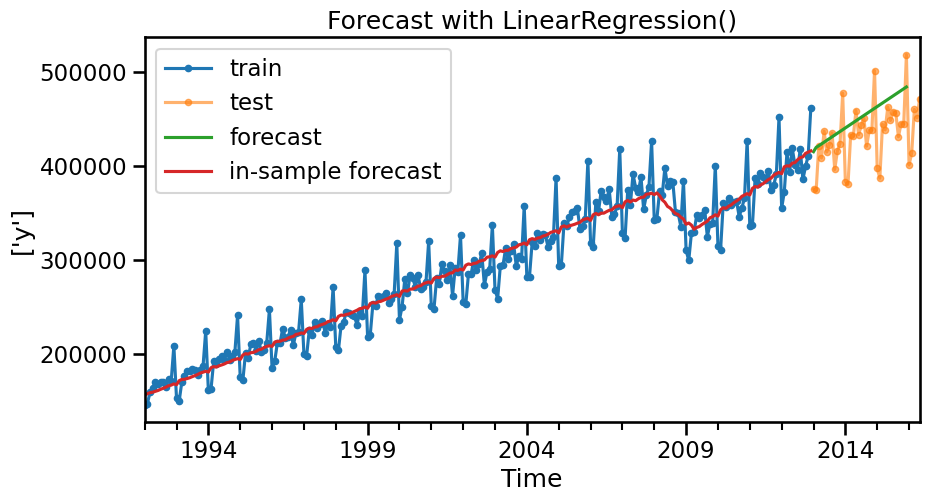

In [89]:
# --- PLOTTING --- #
# Plot the forecast.
fig, ax = plt.subplots(figsize=[10, 5])

# Plot training set.
y_train.plot(ax=ax, marker=".")
# Plot actuals in forecasting horizon.
y_test.plot(ax=ax, marker=".", alpha=0.6)
# Plot forecast.
y_forecast.plot(ax=ax)
# Plot 1 step forecasts in training data.
y_forecast_train.plot(ax=ax)

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlabel("Time")
ax.set_ylabel(f"{target}")
ax.set_title(f"Forecast with {model}")

Let's look at the model coeffecients.

In [90]:
pd.Series(index=X_train.columns, data=model.coef_[0])

time_since_1992-01-01 00:00:00    298382.728869
time_since_2008-01-01 00:00:00   -236088.888860
time_since_2009-04-01 00:00:00    211584.046592
y_lag_1                           -16916.362130
dtype: float64

In [91]:
# Compute error metrics.
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test.loc[y_forecast.index], y_forecast, squared=False)

32645.276865803873

We can now implement a piecewise linear trend to deal with changepoints alongside other features in a recursive forecasting workflow. We can see that the changepoint features can help capture changes in trend in the data when using linear models.

Feel free to change the dates, try different models, and different features!